This notebook contains an example of how to use the code.

In [11]:
from reservoirtaming.layers.reservoirs import RandomReservoir
from reservoirtaming.models.generic import GenericEchoState
from reservoirtaming.layers.output import Residual
from reservoirtaming.training.training import ridge
from reservoirtaming.data.KS import KS

from jax import random
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [12]:
# Setting up our dataset; similar to jonathans
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 2000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

np.random.seed(1)
dns = KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()

In [13]:
# Prepping train and test matrices
# inputs need to be size [time_steps, samples, spatial_points]
# i.e. here they are [10000, 1, 100]
u = np.expand_dims(dns.uu, axis=1)
_, u_train, u_test, _ = np.split(u / np.sqrt(N), 
                                     [N_init, 
                                     (N_init + N_train), 
                                     (N_init + N_train + N_test)], axis=0)

In [14]:
# Setting up model
n_reservoir = 3000
reservoir_args = (0.4, 0.9, 0.1) #input_scale, reservoir_scale, bias_scale

n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, RandomReservoir, reservoir_args,
                  n_out, Residual, output_layer_args)


key = random.PRNGKey(42)
state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [15]:
%%time
# Running the reservoir using method = model.run_reservoir
# Returns a (final_state, intermediate_states) tuple
new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

CPU times: user 1.22 s, sys: 48.5 ms, total: 1.27 s
Wall time: 1.31 s


In [16]:
%%time
# Predicting with random output layer
# Running model.apply without specifying the method actually predicts
# and returns a tuple (final_state, prediction)

n_predict_steps = 100
new_state, prediction = model.apply(params, state, u_train[0], n_predict_steps)

CPU times: user 163 ms, sys: 104 ms, total: 267 ms
Wall time: 302 ms


In [17]:
%%time
# Training; we give the model, state and params
# It runs the reservoir and returns the state after running training and the updated params
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2)

CPU times: user 2.4 s, sys: 329 ms, total: 2.73 s
Wall time: 3.33 s


In [18]:
%%time
# Extrapolate
# We start with the point after training and recursively predict
n_predict_steps = 2000
end_of_predict_state, prediction = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

CPU times: user 442 ms, sys: 45.3 ms, total: 488 ms
Wall time: 528 ms


In [19]:
# Parsing; just removing unnecessary axes
truth  = u_test.squeeze()
prediction = prediction.squeeze()

Text(0.5, 0, 'x')

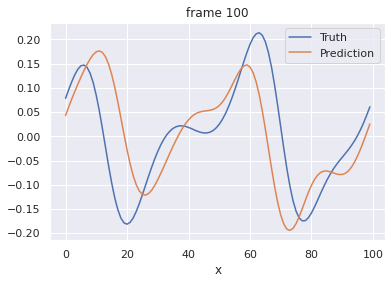

In [20]:
frame = 100
plt.plot(truth[frame], label='Truth')
plt.plot(prediction[frame], label='Prediction')
plt.title(f'frame {frame}')
plt.legend()
plt.xlabel('x')